In [1]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F

In [2]:
from torchvision.io.image import read_image
from torchvision.models.segmentation import deeplabv3_resnet101, DeepLabV3_ResNet101_Weights
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
from torchvision.transforms.functional import to_pil_image

In [3]:
print(torch.__version__)

2.4.0


In [4]:
# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [5]:
IMG_PATH = '/kaggle/input/dl4cv-project-data/train_images'
MASK_PATH = '/kaggle/input/dl4cv-project-data/train_masks'

In [6]:
names = []
for dirname, _, filenames in os.walk(IMG_PATH):
    for filename in filenames:
        names.append(filename.split('.')[0])
    
df = pd.DataFrame({'id': names}, index = np.arange(0, len(names)))
print('Total Images: ', len(df))
print(df.head())

Total Images:  1631
           id
0  train_1117
1  train_0205
2  train_1515
3  train_1224
4  train_1453


In [7]:
from sklearn.model_selection import train_test_split

#split data
X_train, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=42, shuffle=True)
X_val, X_test = train_test_split(X_test, test_size=0.5, random_state=42)

print(f'Train Size: {len(X_train)}')
print(f'Val Size: {len(X_val)}')
print(f'Test Size: {len(X_test)}')

Train Size: 1467
Val Size: 82
Test Size: 82


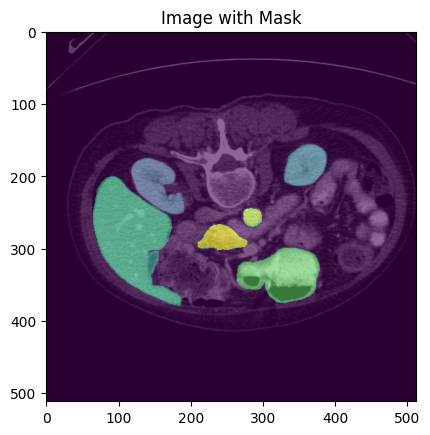

In [8]:
name = 'train_0000.png'
img = Image.open(os.path.join(IMG_PATH, name)).convert('RGB')
mask = Image.open(os.path.join(MASK_PATH, name)).convert('L')


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Image with Mask')
plt.show()

In [9]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomHorizontalFlip(),  # random flipping
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
class MedicalDataSet(Dataset):
    """Medical dataset"""
    
    def __init__(self, img_path, mask_path, df, transform=None):
        self.image_path = img_path
        self.mask_path = mask_path
        self.df = df
        self.transform = transform
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(IMG_PATH, self.df[idx] + '.png')).convert('RGB')
        mask = Image.open(os.path.join(MASK_PATH, self.df[idx] + '.png')).convert('L')
        mask = torch.from_numpy(np.array(mask)).long()
        
        if self.transform is not None:
            t_img = self.transform(img) 
            return t_img, mask
        
        if self.transform is None:  # normalize img yurr
            img = torch.from_numpy(np.array(img)).long()
            return img, mask
    
    def __len__(self):
        return len(self.df)

In [11]:
#datasets
train_set = MedicalDataSet(IMG_PATH, MASK_PATH, X_train, transform=data_transforms['train'])
val_set = MedicalDataSet(IMG_PATH, MASK_PATH, X_val, transform=data_transforms['val'])
test_set = MedicalDataSet(IMG_PATH, MASK_PATH, X_test, transform=data_transforms['val'])  # same transformation for val and test

In [12]:
#dataloader
batch_size= 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False) 

In [13]:
# weights = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1
# model = deeplabv3_mobilenet_v3_large(weights=weights)
# model_name = 'MobileNet_V3'

weights = DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
model = deeplabv3_resnet50(weights=weights)
model_name = 'ResNet50'

# weights = DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
# model = deeplabv3_resnet101(weights=weights)
# model_name = 'ResNet101'

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 91.1MB/s] 


In [16]:
num_classes = 9

# modify classifier head to output 9 classes 
model.classifier[4] = nn.Conv2d(in_channels=256,
                                out_channels=num_classes,
                                kernel_size=1,
                                stride=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [18]:
def mIoU(pred_mask, mask, smooth=1e-10, num_classes=9):  
    # what happens when pred_mask are multile predictions for all examples in the batch when you iterate the dataloader
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.reshape(-1)  # flatten into 1d-tensor
        mask = mask.reshape(-1)

        iou_per_class = []
        for c in range(0, num_classes):  # loop through each class
            pred_label = pred_mask == c  # predicted pixels that == class c
            true_label = mask == c  # ground truth pixels that == class c

            if true_label.long().sum().item() == 0:  # no label in this loop because of the absence of the class in the current image
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(pred_label, true_label).sum().float().item()
                union = torch.logical_or(pred_label, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)  # mean iou (ignore NaNs)

In [19]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler):  #, patch=False
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = [] 
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 0  # 0
    not_improve=0

    model.to(device)
    
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        
        # train loop
        model.train()
        for _, data in enumerate(train_loader,0):
            image, mask = data       
            image = image.to(device)
            mask = mask.to(device)
            
            # forward
            output = model(image)['out']
            loss = criterion(output, mask)
            
            # evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            
            # backward
            loss.backward()
            optimizer.step()       
            optimizer.zero_grad()
            
            # lr scheduler
            lrs.append(get_lr(optimizer))
            scheduler.step()
#             scheduler.step(iou_score)  # new scheduler
            
            running_loss += loss.item()
            
        else:  # else block after for/while loop is executed only when the loop is not terminated by a break statement
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            
            # validation loop
            with torch.no_grad():
                for _, data in enumerate(val_loader,0):  # i
                    image, mask = data
                    image = image.to(device)
                    mask = mask.to(device)
                    output = model(image)['out']
                    
                    # evaluation metrics
                    val_iou_score +=  mIoU(output, mask)  # 9 mIoUs averaged together (each of the 9 mIoUs was calculated for all examples in the batch?)
                    test_accuracy += pixel_accuracy(output, mask)
                    
                    # loss
                    loss = criterion(output, mask)                                 
                    test_loss += loss.item()
            
            # mean loss for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print(f'Loss Decreasing.. {min_loss:.3f} >> {(test_loss/len(val_loader)):.3f}')
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, f'Deeplabv3_{model_name}_mIoU-{val_iou_score/len(val_loader):.3f}.pt')

                               
#             if (test_loss/len(val_loader)) > min_loss:
#                 not_improve += 1
#                 min_loss = (test_loss/len(val_loader))
#                 print(f'Loss did not decrease for {not_improve} time(s)')
#                 if not_improve == 5:  # 3
#                     print('Loss has not decreased for 3 times, early stopping')
#                     break
            
            # iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print(f'Epoch {e+1}/{epochs}:',
                  f'Train Loss: {running_loss/len(train_loader):.3f}..',
                  f'Val Loss: {test_loss/len(val_loader):.3f}..',
                  f'Train mIoU:{iou_score/len(train_loader):.3f}..',
                  f'Val mIoU: {val_iou_score/len(val_loader):.3f}..',  # len(val_loader) is the number of minibatches
                  f'Train Acc:{accuracy/len(train_loader):.3f}..',
                  f'Val Acc:{test_accuracy/len(val_loader):.3f}..',
                  f'Time: {(time.time()-since)/60:.2f}m'
                 )
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,  # val_iou of the 15 epochs
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print(f'Total time: {(time.time()- fit_time)/60:.2f} m')
    return history

In [20]:
# focal_loss = torch.hub.load(
#     'adeelh/pytorch-multi-class-focal-loss',
#     model='FocalLoss',
#     alpha=torch.tensor([.0125, .1, .1, .1, .3625, .025, .1, .1, .15]),
#     gamma=2,
#     reduction='mean',
#     force_reload=False
# )
# focal_loss.to(device)

In [21]:
import typing
from typing import List
from typing import Optional
from torch import Tensor
from torch.nn.modules.loss import _Loss


def to_tensor(x, dtype=None) -> torch.Tensor:
    if isinstance(x, torch.Tensor):
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, np.ndarray) and x.dtype.kind not in {"O", "M", "U", "S"}:
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x
    if isinstance(x, (list, tuple)):
        x = np.ndarray(x)
        x = torch.from_numpy(x)
        if dtype is not None:
            x = x.type(dtype)
        return x

    raise ValueError("Unsupported input type" + str(type(x)))


def soft_dice_score(
    output: torch.Tensor, target: torch.Tensor, smooth: float = 0.0, eps: float = 1e-7, dims=None
) -> torch.Tensor:
    """

    :param output:
    :param target:
    :param smooth:
    :param eps:
    :return:

    Shape:
        - Input: :math:`(N, NC, *)` where :math:`*` means any number
            of additional dimensions
        - Target: :math:`(N, NC, *)`, same shape as the input
        - Output: scalar.

    """
    assert output.size() == target.size()
    if dims is not None:
        intersection = torch.sum(output * target, dim=dims)
        cardinality = torch.sum(output + target, dim=dims)
    else:
        intersection = torch.sum(output * target)
        cardinality = torch.sum(output + target)
    dice_score = (2.0 * intersection + smooth) / (cardinality + smooth).clamp_min(eps)
    return dice_score


__all__ = ["DiceLoss"]

BINARY_MODE = "binary"
MULTICLASS_MODE = "multiclass"
MULTILABEL_MODE = "multilabel"


class DiceLoss(_Loss):
    """
    Implementation of Dice loss for image segmentation task.
    It supports binary, multiclass and multilabel cases
    """

    def __init__(
        self,
        mode: str,
        classes: List[int] = None,
        log_loss=False,
        from_logits=True,
        smooth: float = 0.0,
        ignore_index=None,
        eps=1e-7,
    ):
        """

        :param mode: Metric mode {'binary', 'multiclass', 'multilabel'}
        :param classes: Optional list of classes that contribute in loss computation;
        By default, all channels are included.
        :param log_loss: If True, loss computed as `-log(jaccard)`; otherwise `1 - jaccard`
        :param from_logits: If True assumes input is raw logits
        :param smooth:
        :param ignore_index: Label that indicates ignored pixels (does not contribute to loss)
        :param eps: Small epsilon for numerical stability
        """
        assert mode in {BINARY_MODE, MULTILABEL_MODE, MULTICLASS_MODE}
        super(DiceLoss, self).__init__()
        self.mode = mode
        if classes is not None:
            assert mode != BINARY_MODE, "Masking classes is not supported with mode=binary"
            classes = to_tensor(classes, dtype=torch.long)

        self.classes = classes
        self.from_logits = from_logits
        self.smooth = smooth
        self.eps = eps
        self.ignore_index = ignore_index
        self.log_loss = log_loss

    def forward(self, y_pred: Tensor, y_true: Tensor) -> Tensor:
        """

        :param y_pred: NxCxHxW
        :param y_true: NxHxW
        :return: scalar
        """
        assert y_true.size(0) == y_pred.size(0)

        if self.from_logits:
            # Apply activations to get [0..1] class probabilities
            # Using Log-Exp as this gives more numerically stable result and does not cause vanishing gradient on
            # extreme values 0 and 1
            if self.mode == MULTICLASS_MODE:
                y_pred = y_pred.log_softmax(dim=1).exp()
            else:
                y_pred = F.logsigmoid(y_pred).exp()

        bs = y_true.size(0)
        num_classes = y_pred.size(1)
        dims = (0, 2)

        if self.mode == BINARY_MODE:
            y_true = y_true.view(bs, 1, -1)
            y_pred = y_pred.view(bs, 1, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        if self.mode == MULTICLASS_MODE:
            y_true = y_true.view(bs, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask.unsqueeze(1)

                y_true = F.one_hot((y_true * mask).to(torch.long), num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1) * mask.unsqueeze(1)  # H, C, H*W
            else:
                y_true = F.one_hot(y_true, num_classes)  # N,H*W -> N,H*W, C
                y_true = y_true.permute(0, 2, 1)  # H, C, H*W

        if self.mode == MULTILABEL_MODE:
            y_true = y_true.view(bs, num_classes, -1)
            y_pred = y_pred.view(bs, num_classes, -1)

            if self.ignore_index is not None:
                mask = y_true != self.ignore_index
                y_pred = y_pred * mask
                y_true = y_true * mask

        scores = soft_dice_score(y_pred, y_true.type_as(y_pred), smooth=self.smooth, eps=self.eps, dims=dims)

        if self.log_loss:
            loss = -torch.log(scores.clamp_min(self.eps))
        else:
            loss = 1.0 - scores

        # Dice loss is undefined for non-empty classes
        # So we zero contribution of channel that does not have true pixels
        # NOTE: A better workaround would be to use loss term `mean(y_pred)`
        # for this case, however it will be a modified jaccard loss

        mask = y_true.sum(dims) > 0
        loss *= mask.to(loss.dtype)

        if self.classes is not None:
            loss = loss[self.classes]

        return loss.mean()

In [22]:
class weighted_loss(nn.Module):
    def __init__(self, reduction='mean', lamb=1.25):
        super().__init__()
        self.reduction = reduction
        self.lamb = lamb
        self.base_loss = torch.nn.CrossEntropyLoss(reduction=reduction)
        self.dice_loss = DiceLoss(mode='multiclass')
        
    def forward(self, logits, target):
        base_l = self.base_loss(logits, target)
        dice_l = self.dice_loss(logits, target)
        
        return base_l + self.lamb * dice_l

In [23]:
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

# loss_fn = nn.CrossEntropyLoss()
# loss_fn = focal_loss
# loss_fn = DiceLoss(mode='multiclass')
loss_fn = weighted_loss()

optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.1,
#     patience=5,
#     threshold=1e-4)

history = fit(epoch, model, train_loader, val_loader, loss_fn, optimizer, sched)

Loss Decreasing.. inf >> 1.510
Epoch 1/25: Train Loss: 2.242.. Val Loss: 1.510.. Train mIoU:0.310.. Val mIoU: 0.511.. Train Acc:0.870.. Val Acc:0.977.. Time: 8.30m
Loss Decreasing.. 1.510 >> 0.748
Epoch 2/25: Train Loss: 1.158.. Val Loss: 0.748.. Train mIoU:0.585.. Val mIoU: 0.688.. Train Acc:0.982.. Val Acc:0.987.. Time: 8.12m
Loss Decreasing.. 0.748 >> 0.431
Epoch 3/25: Train Loss: 0.529.. Val Loss: 0.431.. Train mIoU:0.703.. Val mIoU: 0.672.. Train Acc:0.986.. Val Acc:0.979.. Time: 8.12m
Loss Decreasing.. 0.431 >> 0.211
Epoch 4/25: Train Loss: 0.272.. Val Loss: 0.211.. Train mIoU:0.774.. Val mIoU: 0.807.. Train Acc:0.989.. Val Acc:0.989.. Time: 8.12m
Epoch 5/25: Train Loss: 0.235.. Val Loss: 0.257.. Train mIoU:0.782.. Val mIoU: 0.752.. Train Acc:0.989.. Val Acc:0.987.. Time: 8.09m
Epoch 6/25: Train Loss: 0.203.. Val Loss: 0.274.. Train mIoU:0.802.. Val mIoU: 0.745.. Train Acc:0.990.. Val Acc:0.983.. Time: 8.10m
Loss Decreasing.. 0.211 >> 0.144
saving model...
Epoch 7/25: Train Loss:

In [24]:
# testing mIoU below 

In [25]:
def _mIoU(pred_mask, mask, smooth=1e-10, num_classes=9):  
    # what happens when pred_mask are multile predictions for all examples in the batch when you iterate the dataloader
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.reshape(-1)  # flatten into 1d-tensor
        mask = mask.reshape(-1)

        iou_per_class = []
        for c in range(0, num_classes):  # loop through each class
            pred_label = pred_mask == c  # predicted pixels that == class c
            true_label = mask == c  # ground truth pixels that == class c

            if true_label.long().sum().item() == 0:  # no label in this loop because of the absence of the class in the current image
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(pred_label, true_label).sum().float().item()
                union = torch.logical_or(pred_label, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return iou_per_class, np.nanmean(iou_per_class)  # mean iou (ignore NaNs)

In [26]:
# iou for val set per class
# history['val_miou']
yo_imgs, yo_masks = next(iter(val_loader))
print(yo_imgs.shape)  # 8x3x512x512 (8 examples per batch)

yo_imgs = yo_imgs.to(device)
yo_masks = yo_masks.to(device)
model.eval()
model.to(device)

_outputs = model(yo_imgs)['out']
_pred_mask = F.softmax(_outputs, dim=1)
_pred_mask = torch.argmax(_outputs, dim=1)
print(_pred_mask.shape)  # 8 predict masks of size 512x512
yurr = _pred_mask == 1
print(yurr.shape)

print(_mIoU(_outputs, yo_masks))


torch.Size([8, 3, 512, 512])
torch.Size([8, 512, 512])
torch.Size([8, 512, 512])
([0.9947440903837292, 0.9461090752317313, 0.8968617771509186, 0.9079368252698929, 0.7254901960784583, 0.9455491273275318, 0.9051059140443253, 0.9178845864095236, 0.6867570385818627], 0.8807154033864416)


In [27]:
# end testing
cuh

NameError: name 'cuh' is not defined

In [ ]:
def predict_image_mask_miou(model, image, mask):
    model.eval()
    model.to(device)
    
    image = image.to(device)
    mask = mask.to(device)
    
    with torch.no_grad():    
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)['out']
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
def predict_image_mask_pixel(model, image, mask):
    model.eval()
    model.to(device)
    
    image = image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)['out']
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in range(len(test_set)):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
image, mask = test_set[42]
pred_mask, score = predict_image_mask_miou(model, image, mask)

In [ ]:
mob_miou = miou_score(model, test_set)
# print(mob_miou)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,10))
ax1.imshow(image.permute(1,2,0))
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title(f'Model | mIoU {score:.3f}')
ax3.set_axis_off()

## 